## 6.1 对偶表示

机器学习模型可以大致分为两类。

一种类似于神经网络、线性回归等，我们选用一些数学函数，通过在训练集上迭代训练以调节参数，最终我们得到这个包含数学函数和参数的模型，预测新数据时只需将新数据传入模型。 

另一种方法在对新数据做预测时需要训练数据。包含两种情况：
1. 保留全部训练数据，如KNN和这章的Gaussian process。
2. 保留部分训练数据，如SVM只需保存支持向量。
每当预测新数据时，使用某种度量方法，用存储的训练集数据预测新数据。这种方法往往训练速度很快或者根本不需要训练，然而预测可能会比较慢。 

对于基于固定非线性特征空间映射$\phi(x)$的模型来说，核函数形式为:
$$k(x,x')=\phi(x)^T\phi(x')$$
回归和分类的线性模型都可以用对偶表示重写，如一个线性模型，其参数通过最小正则化平方和误差函数来确定：
$$J(w)=\frac{1}{2}\sum_{n=1}^{N}\{w^T\phi(x_n)-t_n\}^2+\frac{\lambda}{2}w^Tw$$
可以解出:
$$w=-\frac{1}{\lambda}\sum_{n=1}^N\{w^T\phi(x_n)-t_n\}\phi(x_n)=\sum_{n=1}^Na_n\phi(x_n)=\Phi^Ta$$
其中$\Phi$的第n行为$\phi(x_n)^T$，其中
$$a_n=-\frac{1}{\lambda}\{w^T\phi(x_n)-t_n\}$$
将$w=\Phi^Ta$代入$J(w)$可以得到：
$$J(a)=\frac{1}{2}a^T\Phi\Phi^T\Phi\Phi^Ta-a^T\Phi\Phi^Tt+\frac{1}{2}t^Tt+\frac{\lambda}{2}a^T\Phi\Phi^Ta$$
定义Gram矩阵$K=\Phi\Phi^T$,一个NxN的对称矩阵，原为:
$$K_{nm}=\phi(x_n)^T\phi(x_m)=k(x_n,x_m)$$
平方和误差函数可以写成:
$$
J(a)=\frac{1}{2}a^TKKa-a^TKt+\frac{1}{2}t^Tt+\frac{\lambda}{2}a^TKa
$$
再求解a:
$$a=(K+\lambda I_N)^{-1}t$$
再代入线性模型，对于新的x，可以预测：
$$y(x)=w^T\phi(x)=a^T\Phi\phi(x)=k(x)^T(K+\lambda I_N)^{-1}t$$
对偶公式使得最⼩平⽅
问题的解完全通过核函数$k(x; x′)$表示，因为a的解可以被表⽰为$\phi(x)$的线性组合，从⽽我们可以使⽤参数向量$w$恢复出原始的公式。
对偶公式的优点是，它可以完全通过核
函数$k(x; x′)$来表⽰。于是，我们可以直接针对核函数进⾏计算，避免了显式地引⼊特征向
量$\phi(x)$，这使得我们可以隐式地使⽤⾼维特征空间，甚⾄⽆限维特征空间。

In [2]:
import sys
sys.path.append(r"../")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.kernel import (
    PolynomialKernel,
    RBF,
    GaussianProcessClassifier,
    GaussianProcessRegressor
)

In [3]:
def create_toy_data(func, n=10, std=1., domain=[0., 1.]):
    x = np.linspace(domain[0], domain[1], n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

def sinusoidal(x):
        return np.sin(2 * np.pi * x)

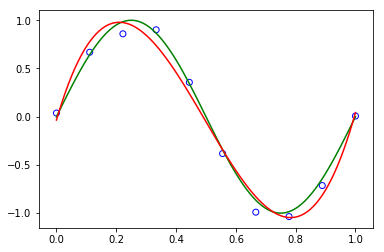

In [4]:
x_train, y_train = create_toy_data(sinusoidal, n=10, std=0.1)
x = np.linspace(0, 1, 100)

model = GaussianProcessRegressor(kernel=PolynomialKernel(3, 1.), beta=int(1e10))
model.fit(x_train, y_train)

y = model.predict(x)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, y, color="r", label="gpr")
plt.show()

## 6.2核函数的构造

#### 特征空间映射
1. 选择一个特征空间映射，使用该映射寻找核函数，$$k(x,x')=\phi(x)^T\phi(x')=\sum_{i=1}^N\phi_i(x)\phi_i(x')$$
2. 直接构造核函数,核函数对应于某个特征空间的标量积，例如
$$\begin {align}k(x,z)&=(x^Tz)^2=x(x_1z_1+x_2z_2)^2\\
&=x_1^2z_1^2+2x_1z_1x_2z_2+x_2^2z_2^2\\
&=(x_1^2,\sqrt2 x_1x_2,x_2^2)(z_1^2,\sqrt2 z_1z_2,z_2^2)^T\\
&=\phi(x)^T\phi(z)\end {align}$$
3. 可以证明两个 kernel 函数相加、相乘后都还是 kernel；一个 kernel 乘上一个正数后也还是 kernel；一个 kernel 的指数函数也还是 kernel。 基于这些性质，可以通过简单的 kernel 构造出复杂的 kernel。
例如高斯核：
$$k(x,x')=exp\bigg(-\frac{\lVert x-x'\lVert^2}{2\sigma^2}\bigg)$$
$$\lVert x-x'\lVert^2=x^Tx+(x')^Tx'-2x^Tx'$$
$$k(x,x')=exp(-\frac{x^Tx}{2\sigma^2})exp(-\frac{x^Tx'}{\sigma^2})exp(-\frac{(x')^Tx'}{2\sigma^2})$$

#### 由生成模型构造核函数

1. 给定一个生成模型$p(x)$,可以定义一个核：$k(x,x')=p(x)p(x')$，$p(x)$是一个从D维空间到1维空间的特征映射，根据核函数的性质，考虑不同概率分布的乘积的加和，可以得到更复杂的形式$$k(x,x')=\sum_ip(x|i)p(x'|i)p(i)$$
$p(i)$为隐变量（分布）,考虑隐马尔科夫模型，可以使用一个核函数来度量两个序列的相似度(两个观测序列都通过相同哦你没个的状态序列Z生成)。
$$k(X,X')=\sum_Zp(X|Z)p(X'|Z)p(Z)$$
2. 另一种方法为Fish核,考虑一个生成式模型$p(x|\theta)$，目标是找到一个核来度量这个生成式模型两个输入变量$x$


常见的[kernel](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/)